In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

import cv2
import Imath
import OpenEXR
import maxflow
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

import torch

from lumivid.sky_ground_segmentation.train import get_model as get_ground_model
from lumivid.sky_cloud_segmentation_dl.train import get_model as get_cloud_model
from lumivid.utils.model_utils import load_model
from lumivid.utils.random_utils import set_seed

DATA_PATH = '../data/'
DONG_PATH = DATA_PATH + 'dong/'

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
set_seed(SEED)

In [3]:
scene_mapping = {
    1: 8,
    2: 1,
    3: 3,
    4: 6,
    5: 2,
    6: 5,
    7: 4,
    8: 7,
    9: 10,
    10: 9,
}

def get_image_from_exr_file(file_path):
    file = OpenEXR.InputFile(file_path)

    # Get the image data window and size
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read the three color channels (assuming RGB format)
    r_str = file.channel('R', Imath.PixelType(Imath.PixelType.FLOAT))
    g_str = file.channel('G', Imath.PixelType(Imath.PixelType.FLOAT))
    b_str = file.channel('B', Imath.PixelType(Imath.PixelType.FLOAT))

    # Convert channel data to numpy arrays
    r = np.frombuffer(r_str, dtype=np.float32)
    g = np.frombuffer(g_str, dtype=np.float32)
    b = np.frombuffer(b_str, dtype=np.float32)

    # Reshape arrays to 2D
    r.shape = (size[1], size[0])
    g.shape = (size[1], size[0])
    b.shape = (size[1], size[0])

    # Stack channels to get RGB image
    img = np.dstack((r, g, b))

    return img

def reinhard_tone_map(hdr_img):
    # Convert HDR to 32-bit floating point
    hdr_img_32f = hdr_img.astype(np.float32)

    if np.any(np.isnan(hdr_img_32f)):
        nan_mask = np.isnan(hdr_img_32f)
        hdr_img_32f[nan_mask] = np.nanmax(hdr_img_32f)

    # Create the tone mapper
    tonemapReinhard = cv2.createTonemapReinhard(1, 0, 0, 0)
    ldr_img = tonemapReinhard.process(hdr_img_32f.copy())

    # Clip and return
    return np.clip(ldr_img, 0, 1)

def get_ground_mask(
        image,
        model_type = 'deeplabv3mobilenetv3large',
        optimizer_type = 'ranger'
        ):
    model_save_path = f"../data/sky_ground_segmentation/models/{model_type}_{optimizer_type}_pretrained.pth"
    ground_model = get_ground_model(model_type, n_classes=2, pretrained=False)

    # Predict the ground mask using image
    old_image_shape = image.shape
    image = cv2.resize(image, (0, 0), fx=0.25, fy=0.25)
    image = (image - IMAGENET_MEAN) / IMAGENET_STD # Normalize
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE) # To tensor
    load_model(ground_model, model_save_path, force=True)

    ground_model.eval()
    ground_mask = ground_model(image)['out'].cpu().detach().numpy().squeeze()
    ground_mask = np.argmax(ground_mask, axis=0)

    ground_mask = cv2.resize(ground_mask, (old_image_shape[1], old_image_shape[0]), interpolation=cv2.INTER_NEAREST)
    return ground_mask.astype(bool)

def get_cloud_mask(
        image,
        model_type = 'deeplabv3resnet101',
        optimizer_type = 'ranger'
        ):
    model_save_path = f"../data/sky_cloud_segmentation/models/{model_type}_{optimizer_type}_.pth"
    cloud_model = get_cloud_model(n_classes=3)

    # Predict the ground mask using image
    old_image_shape = image.shape
    image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
    image = (image - IMAGENET_MEAN) / IMAGENET_STD # Normalize
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE) # To tensor
    load_model(cloud_model, model_save_path, force=True)

    cloud_model.eval()
    ground_mask = cloud_model(image)['out'].cpu().detach().numpy().squeeze()
    ground_mask = np.argmax(ground_mask, axis=0)

    ground_mask = cv2.resize(ground_mask, (old_image_shape[1], old_image_shape[0]), interpolation=cv2.INTER_NEAREST)
    return ground_mask

In [4]:
def apply_fuzzy_clustering(image, mask=None):
    # Get 1D data
    data = image.ravel().reshape(-1, 1)
    if mask is not None:
        mask_flat = mask.ravel()
        data = data[mask_flat] # Only keep unmasked data

    # Perform fuzzy C-means clustering with 2 clusters (sky and cloud)
    cntr, u, u0, d, jm, p, fpc = fuzz.cmeans(data.T, 2, 2, error=0.005, maxiter=1000, init=None)


    # Assuming the higher centroid value represents sky
    sky_cluster_index = np.argmax(cntr)

    # Get probabilistic map
    probabilistic_map = np.zeros_like(image, dtype=float)
    if mask is not None:
        probabilistic_map[mask] = u[sky_cluster_index]
    else:
        probabilistic_map = u[sky_cluster_index].reshape(image.shape)
    
    return probabilistic_map

def get_seeds(probabilistic_map, seed_type='sky', alpha=0.95):
    assert seed_type in ['sky', 'cloud']
    if seed_type == 'sky':
        seeds = (probabilistic_map > alpha) & (probabilistic_map != 1)
    elif seed_type == 'cloud':
        seeds = (probabilistic_map < (1 - alpha)) & (probabilistic_map != 0)

    return seeds

def data_cost(probabilistic_map, p, is_sky_seed, is_cloud_seed):
    if is_sky_seed:
        return 0, float('inf')
    
    if is_cloud_seed:
        return float('inf'), 0
    
    i, j = p
    prob_sky = probabilistic_map[i, j]
    data_cost_sky = -np.log(prob_sky + 1e-10)
    data_cost_not_sky = -np.log(1 - prob_sky + 1e-10)

    return data_cost_sky, data_cost_not_sky

def interaction_cost(p, q, probabilistic_map, fixed_cost=1.0):
    similarity = np.abs(probabilistic_map[p] - probabilistic_map[q])
    interaction_cost_value = fixed_cost * (1 - similarity)
    
    return interaction_cost_value

def build_graph(probabilistic_map, sky_seeds, cloud_seeds):
    n = probabilistic_map.shape[0]  # Assuming a square nxn array
    g = maxflow.Graph[float](n * n, n * n * 4)  # Estimating the number of edges as 4 per node
    nodeids = g.add_grid_nodes((n, n))

    for i in range(n):
        for j in range(n):
            p = (i, j)
            is_sky_seed = sky_seeds[p]
            is_cloud_seed = cloud_seeds[p]
            data_cost_sky, data_cost_not_sky = data_cost(probabilistic_map, p, is_sky_seed, is_cloud_seed)
            g.add_tedge(nodeids[p], data_cost_sky, data_cost_not_sky)  # Adding terminal edges

            if i > 0:  # Checking for left neighbor
                q = (i-1, j)
                cost = interaction_cost(p, q, probabilistic_map)
                g.add_edge(nodeids[p], nodeids[q], cost, cost)  # Adding edge with interaction cost

            if j > 0:  # Checking for upper neighbor
                q = (i, j-1)
                cost = interaction_cost(p, q, probabilistic_map)
                g.add_edge(nodeids[p], nodeids[q], cost, cost)  # Adding edge with interaction cost

    return g, nodeids

def graph_cut(probabilistic_map, sky_seeds, cloud_seeds, ground_mask):
    g, nodeids = build_graph(probabilistic_map, sky_seeds, cloud_seeds)
    g.maxflow()
    sgm = g.get_grid_segments(nodeids)

    mask = np.int_(np.logical_not(sgm))
    mask[~ground_mask] = -1
    mask += 1

    return mask

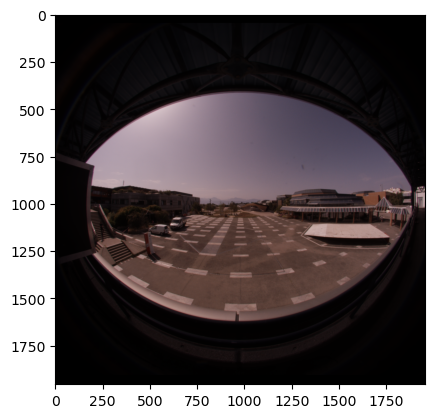

In [49]:
dong_scene_path = f"{DONG_PATH}scene7.exr"
image = get_image_from_exr_file(dong_scene_path)
image = reinhard_tone_map(image)
image = np.nan_to_num(image)

plt.imshow(image)
plt.show()

In [119]:
def get_cloud_percentage(dong_scene_path, method='deeplabv3', show=False):
    assert method in ['graph-cut', 'deeplabv3']
    # Get image
    image = get_image_from_exr_file(dong_scene_path)
    ldr_image = reinhard_tone_map(image)
    ldr_image = np.nan_to_num(ldr_image)
    ground_mask = get_ground_mask(ldr_image)
    ldr_image_not_masked = ldr_image.copy()
    ldr_image = ldr_image * np.expand_dims(ground_mask, axis=-1)
    image = image * np.expand_dims(ground_mask, axis=-1)

    if show:
        plt.imshow(ldr_image)
        plt.title("Original Image")
        plt.show()

    if method == 'deeplabv3':
        cloud_mask = get_cloud_mask(ldr_image)
        print(np.unique(cloud_mask))
    else:
        # Get discriminative channel
        r_channel = image[:,:,0]
        b_channel = image[:,:,2]
        y_channel = (b_channel - r_channel) / ((b_channel + r_channel) + 1e-8)

        # Get segmentation
        probabilistic_map = apply_fuzzy_clustering(y_channel, ground_mask)
        sky_seeds = get_seeds(probabilistic_map, seed_type='sky', alpha=0.99)
        cloud_seeds = get_seeds(probabilistic_map, seed_type='cloud', alpha=0.99)
        cloud_mask = graph_cut(probabilistic_map, sky_seeds, cloud_seeds, ground_mask)

    # Get cloud percentage
    cloud_percentage = np.sum(cloud_mask == 2) / np.sum(cloud_mask > 0)

    # Show
    # ldr_image where cloud_segment == 0, blue for 1 and red for 2
    show_image = ldr_image_not_masked.copy()
    show_image[cloud_mask == 1] = [0, 0, 1]
    show_image[cloud_mask == 2] = [1, 0, 0]
    if show:
        plt.imshow(show_image)
        plt.title(f"Cloud Segmentation ({cloud_percentage:.2%} cloud coverage)")
        plt.show()

    return cloud_percentage, show_image

In [120]:
data = {}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


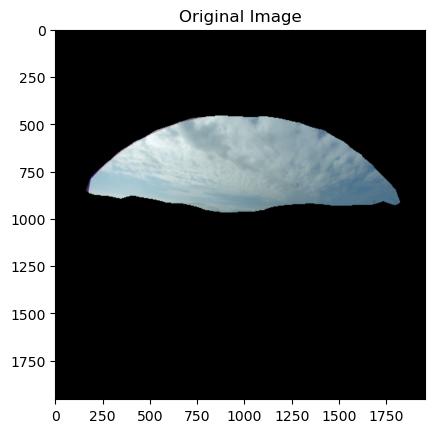

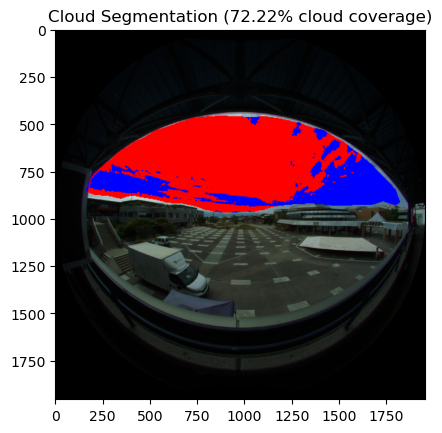

In [121]:
dong_scene_path = f"{DONG_PATH}scene1.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='graph-cut', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


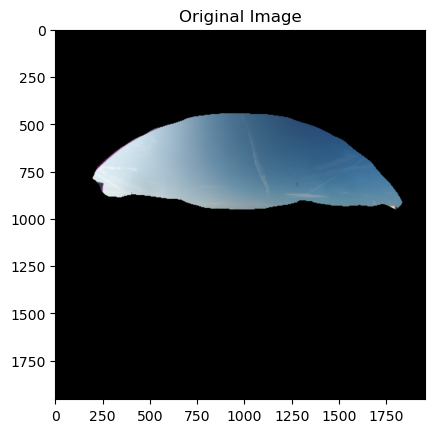

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


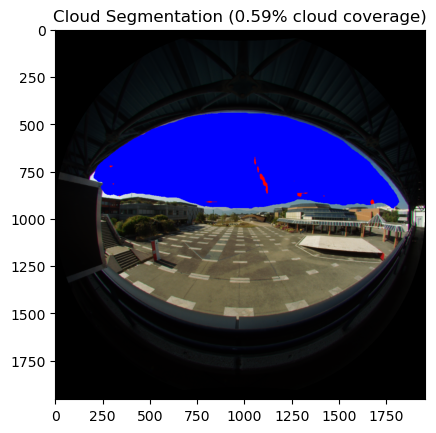

In [134]:
dong_scene_path = f"{DONG_PATH}scene2.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


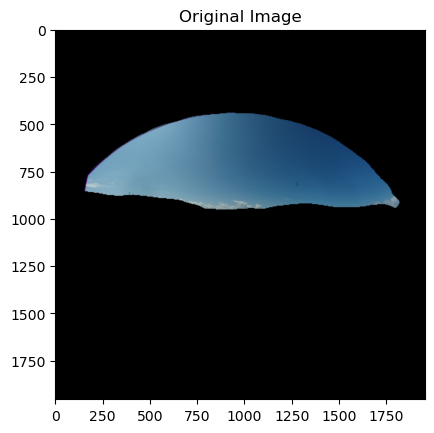

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


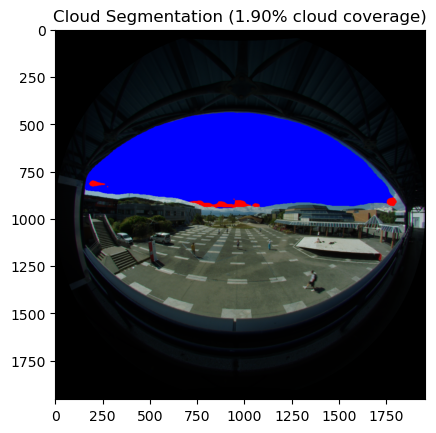

In [136]:
dong_scene_path = f"{DONG_PATH}scene3.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


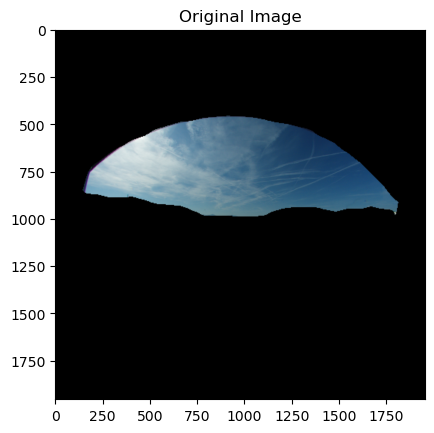

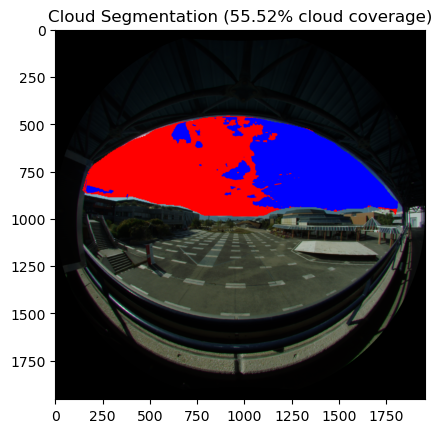

In [137]:
dong_scene_path = f"{DONG_PATH}scene4.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='graph-cut', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


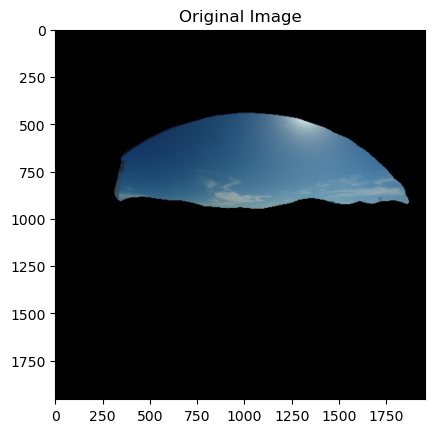

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


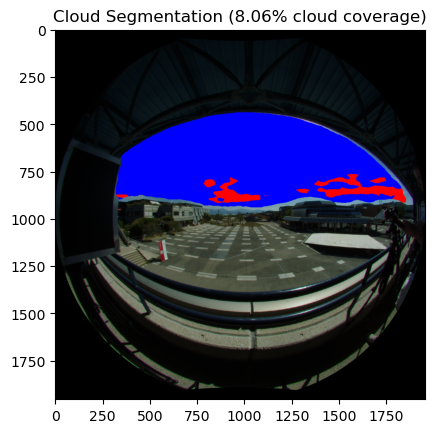

In [138]:
dong_scene_path = f"{DONG_PATH}scene5.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


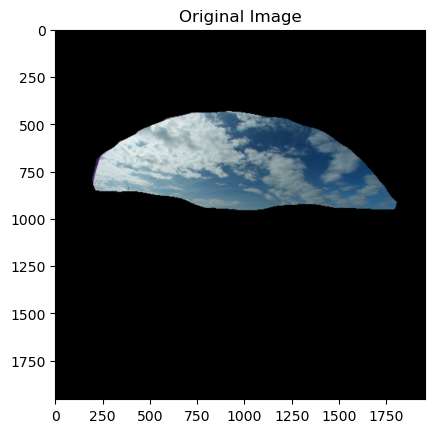

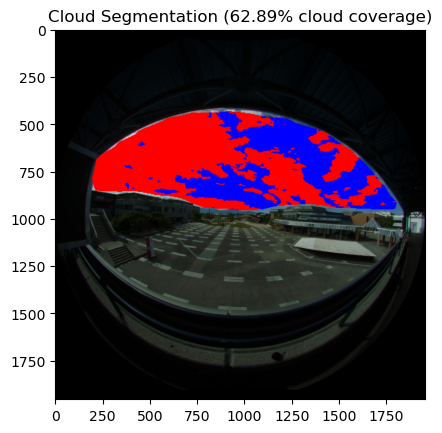

In [139]:
dong_scene_path = f"{DONG_PATH}scene6.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='graph-cut', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


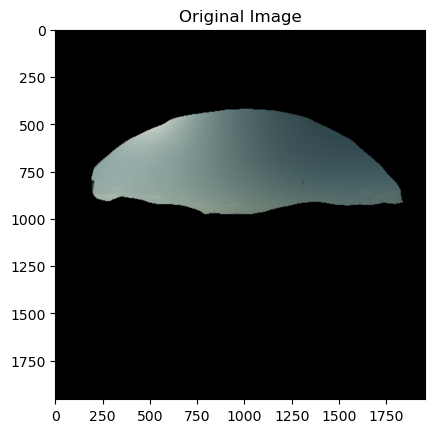

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


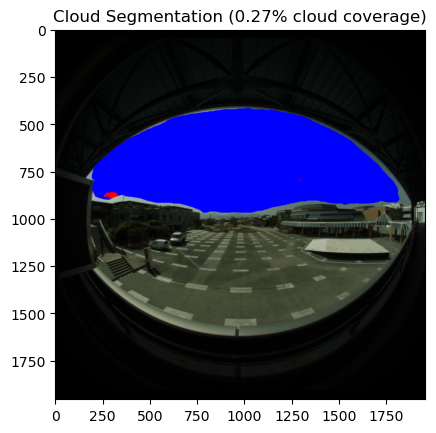

In [147]:
dong_scene_path = f"{DONG_PATH}scene7.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


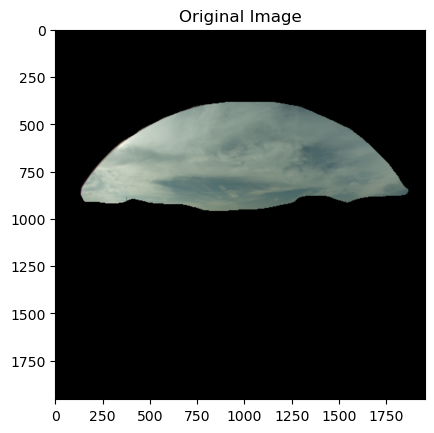

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


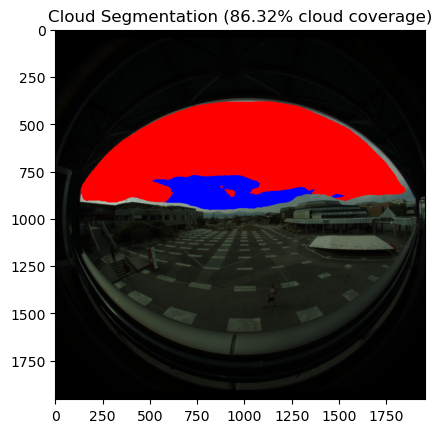

In [148]:
dong_scene_path = f"{DONG_PATH}scene8.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


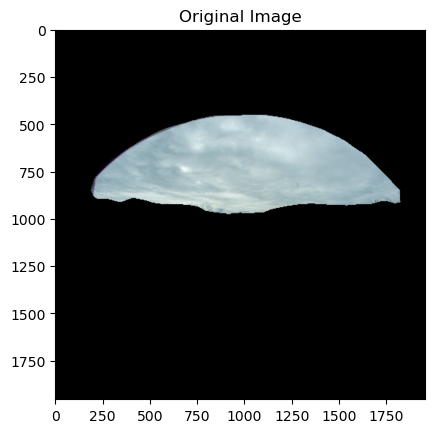

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


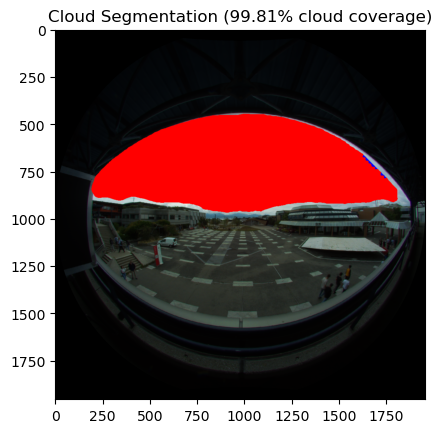

In [150]:
dong_scene_path = f"{DONG_PATH}scene9.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


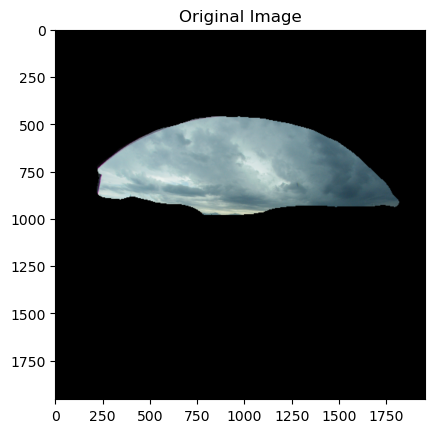

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth
[0 1 2]


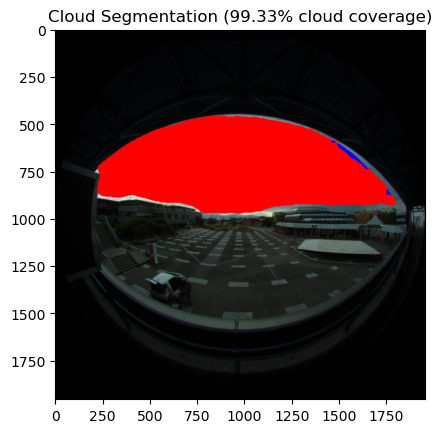

In [151]:
dong_scene_path = f"{DONG_PATH}scene10.exr"
cloud_percentage, show_image = get_cloud_percentage(dong_scene_path, method='deeplabv3', show=True)
data[dong_scene_path.split('/')[-1]] = {'cloud_percentage': cloud_percentage, 'show_image': show_image}

In [152]:
# Save data 
# import pickle
# with open('../data/cloud_percentage.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [5]:
# Load data
import pickle
with open('../data/cloud_percentage.pkl', 'rb') as f:
    data = pickle.load(f)

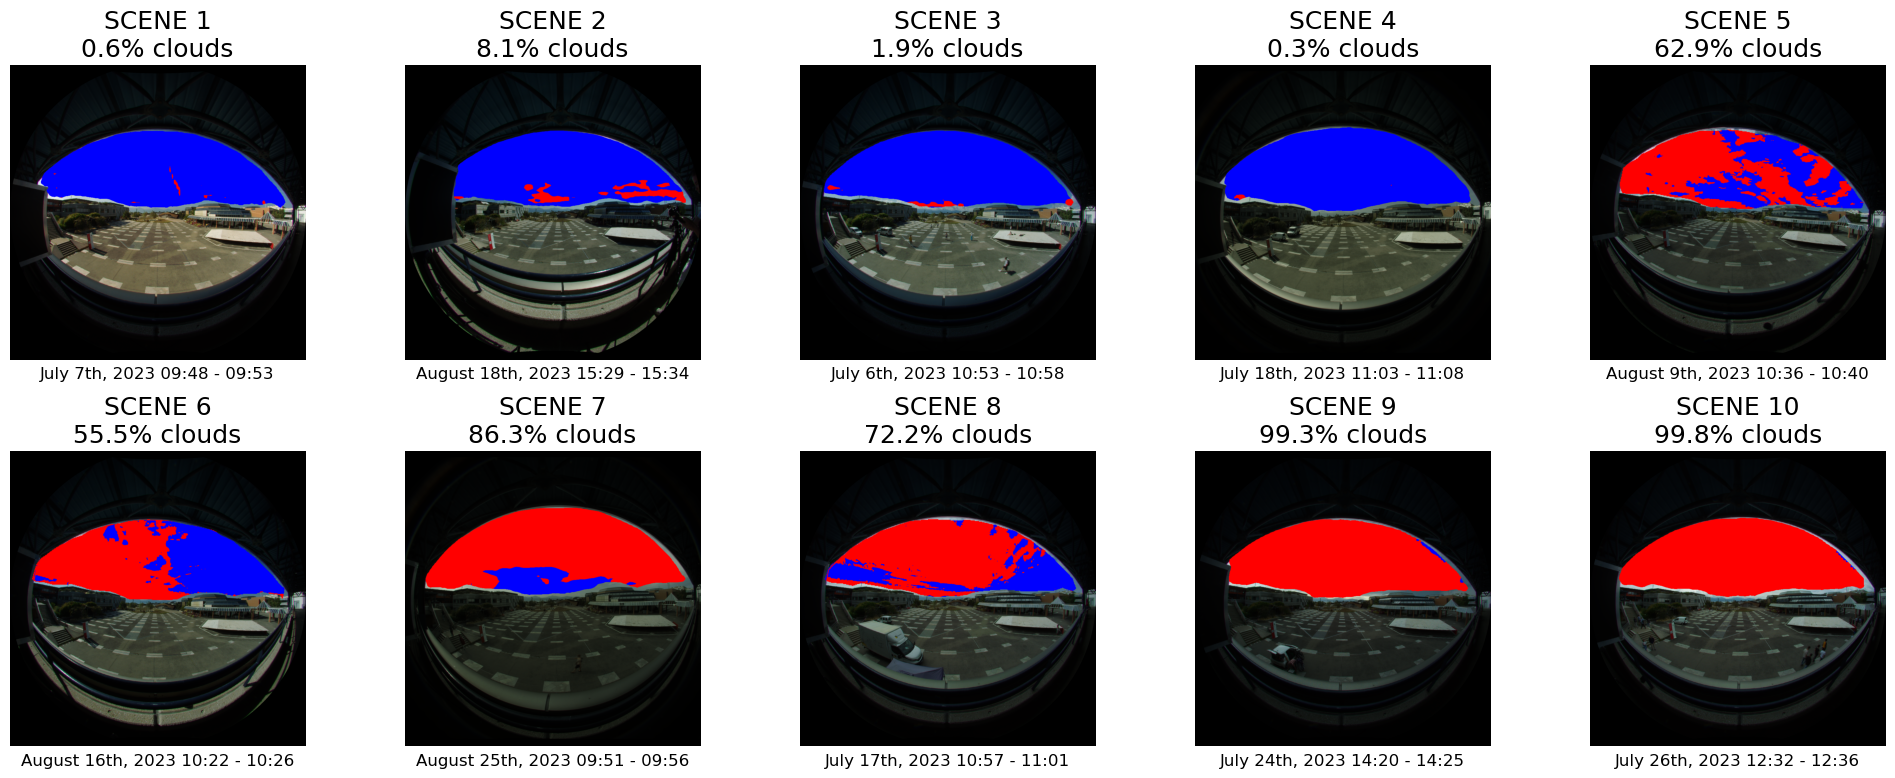

In [7]:
times = [
    "July 7th, 2023 09:48 - 09:53",
    "August 18th, 2023 15:29 - 15:34",
    "July 6th, 2023 10:53 - 10:58",
    "July 18th, 2023 11:03 - 11:08",
    "August 9th, 2023 10:36 - 10:40",
    "August 16th, 2023 10:22 - 10:26",
    "August 25th, 2023 09:51 - 09:56",
    "July 17th, 2023 10:57 - 11:01",
    "July 24th, 2023 14:20 - 14:25",
    "July 26th, 2023 12:32 - 12:36"
]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()
for i in range(1, 11):
    scene_num = scene_mapping[i]
    idx = scene_num - 1

    cloud_percentage = data[f'scene{i}.exr']['cloud_percentage']
    show_image = data[f'scene{i}.exr']['show_image']

    axes[idx].imshow(show_image)
    axes[idx].axis('off')  # Hide the axis
    axes[idx].set_title(f'SCENE {scene_num}\n{cloud_percentage:.1%} clouds', fontsize=18)
    axes[idx].text(0.5, -0.05, times[idx], ha='center', va='center', fontsize=12, transform=axes[idx].transAxes)

plt.tight_layout(pad=2.0)
plt.show()